<a href="https://colab.research.google.com/github/bt22dr/deep-learning-papers/blob/master/code/WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WaveNet

* TODO:
  * text나 speaker ID 컨디션으로 주는 부분 구현 추가

## 캐글에서 LJSpeech-1.1 데이터 다운로드

참조 : https://colab.research.google.com/drive/1DofKEdQYaXmDWBzuResXWWvxhLgDeVyl#scrollTo=akJ8fvsfGVdn

In [0]:
from google.colab import files
files.upload()

In [2]:
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
!kaggle datasets list

ref                                                     title                                              size  lastUpdated          downloadCount  
------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
chicago/chicago-copa-cases                              Chicago COPA Cases                                  3MB  2019-04-05 00:00:32           1422  
himanshupoddar/zomato-bangalore-restaurants             Zomato Bangalore Restaurants                       88MB  2019-03-31 09:48:43           1789  
sfinspiredu/synchrotron-data-set                        Synchrotron Data Set                               10KB  2019-05-27 19:54:29            291  
crisparada/brazilian-cities                             Brazilian Cities                                  935KB  2019-05-24 20:49:21            921  
taniaj/australian-election-2019-tweets                  Australian Election 2019 Tweets             

In [3]:
#!kaggle datasets list -s ljspeech
!kaggle datasets download -d dromosys/ljspeech

100% 2.55G/2.56G [00:23<00:00, 85.5MB/s]
100% 2.56G/2.56G [00:23<00:00, 115MB/s] 


In [4]:
!unzip /content/ljspeech.zip
!tar -xjf /content/LJSpeech-1.1.tar.bz2

Archive:  /content/ljspeech.zip
  inflating: LJSpeech-1.1.tar.bz2    


In [5]:
!ls /content/LJSpeech-1.1/
!head /content/LJSpeech-1.1/metadata.csv
!tail /content/LJSpeech-1.1/metadata.csv
#!cat /content/LJSpeech-1.1/README

metadata.csv  README  wavs
LJ001-0001|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
LJ001-0002|in being comparatively modern.|in being comparatively modern.
LJ001-0003|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
LJ001-0004|produced the block books, which were the immediate predecessors of the true printed book,|produced the block books, which were the immediate predecessors of the true printed book,
LJ001-0005|the invention of movable metal letters in the middle of the 

## WaveNet 구현

### 참고 자료: 
* WaveNet 아키텍처: 
  * https://youtu.be/nsrSrYtKkT8?t=1500
* 아래 2개의 WaveNet 구현을 참고하였음.
  * https://github.com/modulabs/Deep-Generative-Models/blob/master/1st/3.Autoregressive%20Models%20-%20Practice/wavenet.ipynb
  * https://github.com/ibab/tensorflow-wavenet
* Causal and Dilated Convolutions에 대한 내용은 아래를 참고
  * https://theblog.github.io/post/convolution-in-autoregressive-neural-networks/
* TODO: 
  * 이 자료 꼭 보자 -> https://www.youtube.com/watch?v=YyUXG-BfDbE


In [6]:
# Install TensorFlow
!pip install tensorflow-gpu
!pip install tensorflow-probability
!pip install librosa
!pip install tqdm

In [0]:
import librosa
import numpy as np
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import Model

tf.enable_eager_execution()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Found GPU at: /device:GPU:0
TensorFlow version: 1.13.1
Eager execution: True


## 하이퍼파라미터

In [0]:
# 음원 관련
sec= 0.3 # WaveNet에서 사용할 음원 길이 (초 단위)
freq = 220.0 # 샘플 데이터로 생성할 사인파의 주파수
sample_rate = 16000 # sampling rate
mu = 256 # mu-law companding 

# WaveNet 관련
batch_size = 1
filter_width = 2
skip_channels = 128 # 256
residual_channels = 256 # 512
dilation_channels = 32
initial_filter_width = 32
filter_width = 2
quantization_channels = 256
post_proc_channels = 256
dilations = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             # 1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             # 1, 2, 4, 8, 16, 32, 64, 128, 256, 512
            ]

(1, 4800)


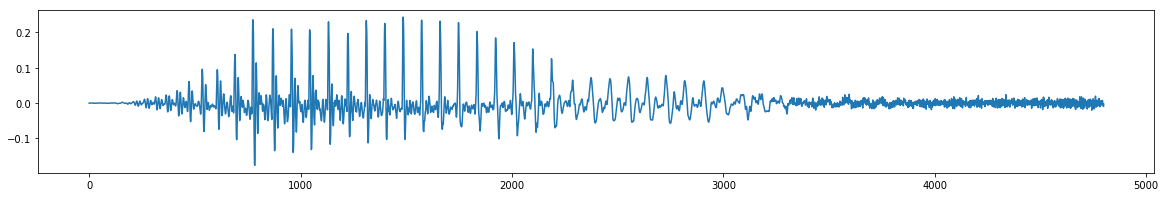

In [10]:
# 참고: https://github.com/modulabs/Deep-Generative-Models/blob/master/1st/3.Autoregressive%20Models%20-%20Practice/wavenet.ipynb

from os import listdir
from os.path import isfile, join
import ntpath

data_dir = '/content/LJSpeech-1.1/wavs'
data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.wav' in f]

def get_patches_from_LJSpeech(batch, time_length, sample_rate=sample_rate):
    
    read_length = 0
    waves = []
    while(read_length < batch * time_length):
        file_index = np.random.randint(0, len(data_files), 1)[0]
        wav, _ = librosa.core.load(data_files[file_index], sr=sample_rate)
        need_length = batch * time_length - read_length
        
        if len(wav) > need_length:
            wav = wav[:need_length]
            
        read_length += len(wav)
        waves.append(wav)
        
    waves = np.concatenate(waves)
    waves = np.reshape(waves, [batch, time_length])
    
    return waves
  
lj_data = get_patches_from_LJSpeech(batch_size, int(sec*sample_rate))
print(lj_data.shape)

plt.figure(figsize=[20, 3])
plt.plot(lj_data[0])
plt.show()

In [11]:
import IPython.display as ipd
ipd.Audio(lj_data[0], rate=sample_rate)

(10, 4800)  => (10 waves, 16000 x 0.3 sec)


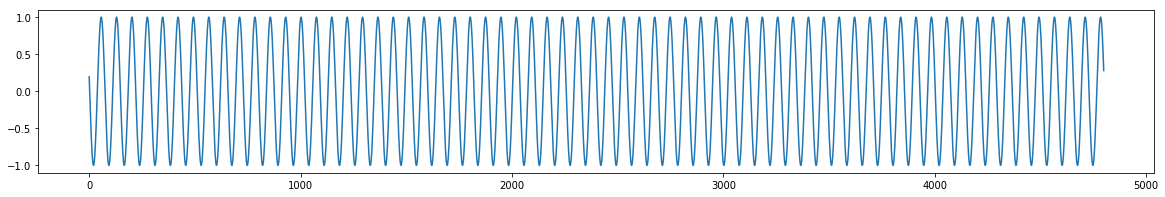

In [12]:
def get_sine_waves(N, sec, freq, sample_rate):
  duration = sec*2
  sine_wave = np.sin(2*np.pi*np.arange(sample_rate*duration)*freq/sample_rate)
  waves = []
  for i in range(N):
    start_index = np.random.randint(0, sec*sample_rate, 1)[0]
    end_index = start_index + int(sec*sample_rate)
    data = sine_wave[start_index:end_index]
    waves.append(data)
  waves = np.concatenate(waves)
  waves = np.reshape(waves, [N, -1])
  return waves

N = 10 # 사인파 음원 개수
sin_data = get_sine_waves(N=N, sec=sec, freq=freq, sample_rate=sample_rate)
print(sin_data.shape, " => ({} waves, {} x {} sec)".format(N, sample_rate, sec))

plt.figure(figsize=[20, 3])
plt.plot(sin_data[0])
plt.show()

In [13]:
import IPython.display as ipd
ipd.Audio(sin_data[0], rate=sample_rate)

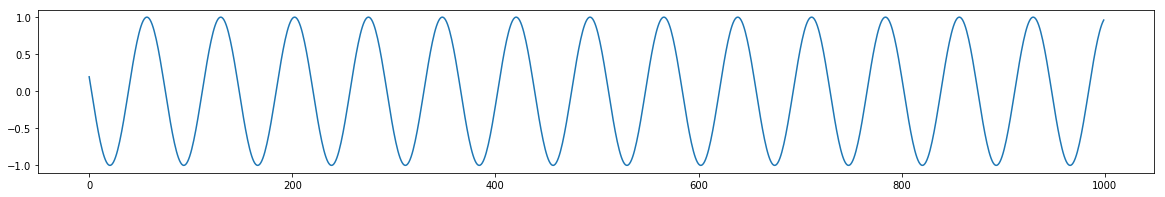

In [14]:
plt.figure(figsize=[20, 3])
plt.plot(sin_data[0][:1000])
plt.show()

### $\mu$-law companding


In [0]:
# 참고: https://github.com/ibab/tensorflow-wavenet

def mu_law_encode(audio, quantization_channels):
    '''Quantizes waveform amplitudes.'''
    with tf.name_scope('encode'):
        mu = tf.cast(quantization_channels - 1, tf.float64)
        # Perform mu-law companding transformation (ITU-T, 1988).
        # Minimum operation is here to deal with rare large amplitudes caused
        # by resampling.
        safe_audio_abs = tf.minimum(tf.abs(audio), 1.0)
        magnitude = tf.math.log1p(mu * safe_audio_abs) / tf.math.log1p(mu)
        signal = tf.sign(audio) * magnitude
        # Quantize signal to the specified number of levels.
        return tf.cast((signal + 1) / 2 * mu + 0.5, tf.int32)


def mu_law_decode(output, quantization_channels):
    '''Recovers waveform from quantized values.'''
    with tf.name_scope('decode'):
        mu = quantization_channels - 1
        # Map values back to [-1, 1].
        signal = 2 * (tf.cast(output, tf.float64) / mu) - 1
        # Perform inverse of mu-law transformation.
        magnitude = (1 / mu) * ((1 + mu)**abs(signal) - 1)
        return tf.sign(signal) * magnitude

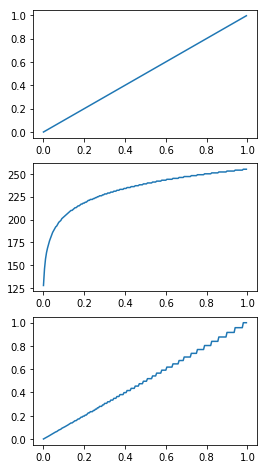

In [16]:
x = np.arange(0, 1, 0.005)

plt.figure(figsize=[4, 8])
ax1 = plt.subplot(311)
plt.plot(x, x)

x_mu_law = mu_law_encode(x, 256)
# print(x_mu_law)
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(x, x_mu_law)

x_recon = mu_law_decode(x_mu_law, 256)
# print(x_recon)
ax2 = plt.subplot(313, sharex=ax1)
plt.plot(x, x_recon)

우선 causal convolution이 예상대로 동작하는지 검증해보자. 아래와 같이 kernel size 2로 잡았을 때 바로 이전의 값과 자신의 값을 제대로 convolution하면서 padding도 제대로 동작하고 있는것을 확인할 수 있다. 

In [17]:
x = tf.cast(tf.reshape([1,2,3,4,5,6], [1,6,1]), tf.float32)
print(x.numpy())

k_size = 2
k_init = tf.constant_initializer(np.ones((k_size,1)))
y = Conv1D(filters=1, kernel_size=k_size, strides=1, padding='causal', kernel_initializer=k_init)(x)
print(y.numpy())

[[[1.]
  [2.]
  [3.]
  [4.]
  [5.]
  [6.]]]
[[[ 1.]
  [ 3.]
  [ 5.]
  [ 7.]
  [ 9.]
  [11.]]]


### WaveNet 모델

In [0]:
class ResBlock(tf.keras.Model):
  def __init__(self, dilation):
    super(ResBlock, self).__init__()

    self.dilation = dilation
    self.conv_filter = Conv1D(
        filters=dilation_channels, kernel_size=initial_filter_width, 
        strides=1, padding='causal', dilation_rate=self.dilation, 
        kernel_initializer='glorot_normal',
        name="filter_conv".format(dilation),
    )
    self.conv_gate = Conv1D(
        filters=dilation_channels, kernel_size=filter_width, 
        strides=1, padding='causal', dilation_rate=self.dilation,
        kernel_initializer='glorot_normal',
        name="gate_conv".format(dilation),
    )
    self.conv_res = Conv1D(
        filters=residual_channels, kernel_size=1, strides=1, 
        dilation_rate=dilation, padding='same', name="residual")
    self.conv_skip = Conv1D(
        filters=skip_channels, kernel_size=1, strides=1, 
        dilation_rate=dilation, padding='same', name="skip")

  def call(self, x):
    # filter & gate => shape: [batch_size, time_steps, 32]
    filter = self.conv_filter(x)
    gate = self.conv_gate(x)

    # z => shape: [batch_size, time_steps, 32]
    z = tf.math.tanh(filter) * tf.math.sigmoid(gate)

    # residual output => shape: [batch_size, time_steps, 512]
    transformed = self.conv_res(z)

    # skip output => shape: [batch_size, time_steps, 256]
    skip_contrib = self.conv_skip(z)

    return skip_contrib, x + transformed

res_block = ResBlock(dilation=2)

In [19]:
sample_data = np.random.random([1, int(sec*sample_rate), residual_channels])
print(sample_data.shape)
out = res_block(sample_data)

(1, 4800, 256)


In [0]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import Model

class WaveNet(tf.keras.Model):
  def __init__(self, dilations):
    super(WaveNet, self).__init__()
    
    # pre-process
    self.conv1 = Conv1D(
        filters=residual_channels, kernel_size=initial_filter_width, 
        strides=1, padding='causal', kernel_initializer='glorot_normal',
        name="pre_causal",
    )
    
    self.res_blocks = []
    for dilation in dilations:
      block = ResBlock(dilation)
      self.res_blocks.append(block)
    
    # post-process
    self.post_conv_1 = Conv1D(
        post_proc_channels, kernel_size=1, strides=1, padding="SAME",
        kernel_initializer='glorot_normal', 
        name='post_1',
    )
    self.post_conv_2 = Conv1D(
        quantization_channels, kernel_size=1, strides=1, padding="SAME",
        kernel_initializer='glorot_normal', 
        name='post_2',
    )

  def call(self, input):
    # input => shape: [batch_size, time_steps, 1]
    # print("input", input.shape)
    
    # 1. Pre-process : causal convolution
    ######################################
    x = self.conv1(input) 
    # => shape: [batch_size, time_steps, 512]
    # print("x", x.shape)
    
    # 2. Dilated convolution Stack
    ######################################
    skips = []
    for block in self.res_blocks:
      skip, x = block(x)
      skips.append(skip)
      
    # 3. Post-process: (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv
    ######################################
    
    # aggregate skip connections => shape: [batch_size, time_steps, 256]
    total = sum(skips)
    
    # post-process 1 => shape: [batch_size, time_steps, 256]
    transformed1 = tf.keras.activations.relu(total)
    post_conv1 = self.post_conv_1(transformed1)
    
    # post-process 2 => shape: [batch_size, time_steps, 256]
    transformed2 = tf.keras.activations.relu(post_conv1)
    post_conv2 = self.post_conv_2(transformed2)
    
    # output => shape: [batch_size, time_steps, 256]
    return post_conv2

wavenet_model = WaveNet(dilations=dilations)
# wavenet_model.summary()

샘플 데이터 만들어서

In [21]:
N = 1
sine_data = get_sine_waves(N=N, sec=sec, freq=freq, sample_rate=sample_rate)
sine_data = mu_law_encode(sine_data, mu)
print(sine_data.shape, " => ({} batches, {} x {} sec)".format(N, sample_rate, sec))

train_data = tf.cast(tf.expand_dims(sine_data, -1), tf.float32)
print("input shape:", train_data.shape)
out = wavenet_model(train_data)
print("output shape:", out.shape)

(1, 4800)  => (1 batches, 16000 x 0.3 sec)
input shape: (1, 4800, 1)
output shape: (1, 4800, 256)


학습이 안된 WaveNet에 입력해서 결과 확인해보면 네트워크가 랜덤 초기화되어 있기 때문에 잡음스러운 결과가 나옴. 
(그래도 사인파를 입력으로 넣었기 때문에 어느 정도는 주기성이 보인다.) 

[ 83 207 107 107 176 126  90  90  90  90]
tf.Tensor(
[-0.02324175  0.12054946 -0.00564304 -0.00564304  0.0284032  -0.00026436
 -0.01611234 -0.01611234 -0.01611234 -0.01611234], shape=(10,), dtype=float64)


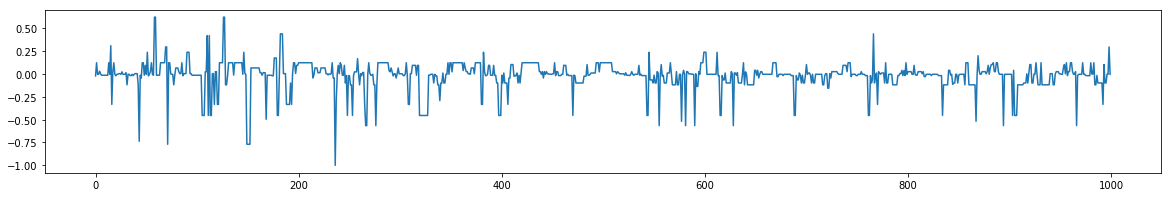

In [22]:
output = np.argmax(out[0], axis=1)
output_wav = mu_law_decode(output, mu)
print(output[:10])
print(output_wav[:10])

x = np.arange(0, int(sec*sample_rate))
plt.figure(figsize=[20, 3]); plt.plot(x[:1000], output_wav.numpy()[:1000])

In [23]:
import IPython.display as ipd
ipd.Audio(output_wav, rate=sample_rate)

In [0]:
def loss(model, x, y):
  y_ = model(x)

  cross_entropy_list = []
  batch_size_ = y.shape[0]
  for i in range(batch_size_):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y[i, 1:], logits=y_[i, :-1])
    cross_entropy_list.append(cross_entropy)
  loss = tf.reduce_mean(cross_entropy_list)
  return loss

In [25]:
sine_data = get_sine_waves(N=1, sec=sec, freq=freq, sample_rate=sample_rate)
sine_data = mu_law_encode(sine_data, mu)

train_data = tf.cast(tf.expand_dims(sine_data, -1), tf.float32)
target_data = sine_data

print(train_data.shape)
print(target_data.shape)

l = loss(wavenet_model, train_data, target_data)
print("Loss test: {}".format(l))

(1, 4800, 1)
(1, 4800)
Instructions for updating:
Use tf.cast instead.
Loss test: 6.0159831047058105


In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [27]:
global_step = tf.Variable(0)
loss_value, grads = grad(wavenet_model, train_data, target_data)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(), loss_value))

Step: 0, Initial Loss: 6.0159831047058105


LJ-Speech 데이터

In [0]:
# lj_data = get_patches_from_LJSpeech(1, int(sec*sample_rate))
# print(lj_data.shape, lj_data[0][:10], type(lj_data[0][0]))
# lj_data_mulaw = mu_law_encode(tf.cast(lj_data, tf.float64), mu)

# # for train
# N = len(lj_data)
# train_dataset = tf.data.Dataset.from_tensor_slices(lj_data_mulaw).shuffle(N)
# train_dataset = train_dataset.batch(batch_size=batch_size)
# train_dataset = train_dataset.repeat()
# print(train_dataset)

사인파 데이터

In [29]:
def generator_sine_wave(batch_size, sec, freq, sample_rate):
  duration = sec*2
  sine_wave = np.sin(2*np.pi*np.arange(sample_rate*duration)*freq/sample_rate)
  waves = []
  for i in range(batch_size):
    start_index = np.random.randint(0, sec*sample_rate, 1)[0]
    end_index = start_index + int(sec*sample_rate)
    data = sine_wave[start_index:end_index]
    waves.append(data)
  waves = np.concatenate(waves)
  waves = tf.cast(mu_law_encode(waves, 256), tf.float64)
  waves = np.reshape(waves, [batch_size, -1])
  
  yield waves

sine_data = generator_sine_wave(
    batch_size=batch_size, sec=sec, freq=freq, sample_rate=sample_rate)
print(sine_data)

<generator object generator_sine_wave at 0x7f60775da8e0>


In [30]:
train_dataset = tf.data.Dataset.from_generator(
    generator_sine_wave, tf.float64, output_shapes=(None, sec*sample_rate), 
    args=(batch_size, sec, freq, sample_rate))
train_dataset = train_dataset.repeat()
print(train_dataset)

for d in train_dataset:
  print(d.shape, np.min(d), np.max(d))
  break

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
<DatasetV1Adapter shapes: (?, 4800), types: tf.float64>
Instructions for updating:
Colocations handled automatically by placer.
(1, 4800) 0.0 255.0


In [0]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [32]:
train_loss_results = []

learning_rate=tf.train.exponential_decay(
            learning_rate=0.001,
            decay_steps=1000,
            global_step=tf.train.get_or_create_global_step(),
            decay_rate=0.9)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)

epoch_loss_avg = tf.contrib.eager.metrics.Mean()

# Training loop 
for epoch in range(10):
  for i, x in enumerate(train_dataset):
    # Optimize the model
    batch_x = tf.cast(tf.expand_dims(x, -1), tf.float32)
    batch_y = tf.cast(x, tf.int32)
    # print("X:", batch_x.shape, batch_x[:5])
    # print("Y:", batch_y.shape, batch_y[:5])

    loss_value, grads = grad(wavenet_model, batch_x, batch_y)
    optimizer.apply_gradients(zip(grads, wavenet_model.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss

    if i % 10 == 0:
      # print("batch_x:", batch_x.shape, np.min(batch_x), np.max(batch_x), np.median(batch_x))
      # print("batch_y:", batch_y.shape, np.min(batch_y), np.max(batch_y), np.median(batch_y))
      # out = wavenet_model(batch_x)
      # print("output:", np.min(out), np.max(out), np.median(out), out.shape)
      # out_wav = np.argmax(out, 2)
      train_loss_results.append(loss_value)
      print("Epoch {:03d} Iter {:03d}: Loss: {:.10f}".format(epoch, i, epoch_loss_avg.result()))
    if i == 100:
      break
      
#   out = wavenet_model(batch_x)
#   out_wav = np.argmax(out, 2)
#   print("batch_y:", batch_y.shape, batch_y[0][:100])
#   print("out_wav:", out_wav.shape, out_wav[0][:100])


Epoch 000 Iter 000: Loss: 6.0174250603
Epoch 000 Iter 010: Loss: 5.3334652294
Epoch 000 Iter 020: Loss: 5.0611140614
Epoch 000 Iter 030: Loss: 4.8540983200
Epoch 000 Iter 040: Loss: 4.6752832576
Epoch 000 Iter 050: Loss: 4.5040667758
Epoch 000 Iter 060: Loss: 4.3478004581
Epoch 000 Iter 070: Loss: 4.1882600348
Epoch 000 Iter 080: Loss: 4.0457695001
Epoch 000 Iter 090: Loss: 3.9237901719
Epoch 000 Iter 100: Loss: 3.8034191202
Epoch 001 Iter 000: Loss: 3.7918649164
Epoch 001 Iter 010: Loss: 3.6881657562
Epoch 001 Iter 020: Loss: 3.5859259387
Epoch 001 Iter 030: Loss: 3.4871017806
Epoch 001 Iter 040: Loss: 3.3932940431
Epoch 001 Iter 050: Loss: 3.3050166384
Epoch 001 Iter 060: Loss: 3.2238588458
Epoch 001 Iter 070: Loss: 3.1451224241
Epoch 001 Iter 080: Loss: 3.0695637700
Epoch 001 Iter 090: Loss: 2.9996429992
Epoch 001 Iter 100: Loss: 2.9318105997
Epoch 002 Iter 000: Loss: 2.9250304769
Epoch 002 Iter 010: Loss: 2.8577575779
Epoch 002 Iter 020: Loss: 2.7982909343
Epoch 002 Iter 030: Loss:

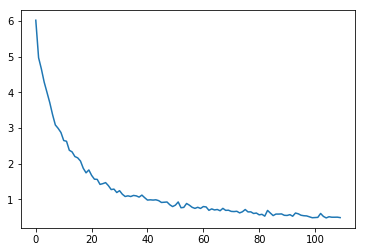

In [33]:
plt.plot(train_loss_results)

앞에서 학습한 wavenet 모델에 음원을 입력하여 샘플 데이터 생성

input shape: (1, 4800, 1)
output shape: (1, 4800, 256)
0 255 [255 249 255 233 238 254 252 246  60  32]
-1.0 1.0 tf.Tensor(
[ 1.          0.76941909  1.          0.38169913  0.47537147  0.95727371
  0.87719895  0.67482301 -0.06993862 -0.24569808], shape=(10,), dtype=float64)


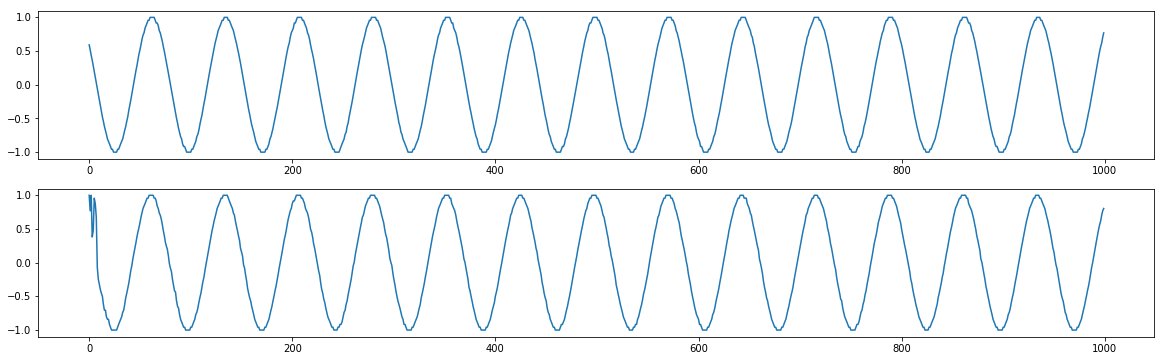

In [34]:
sample_itr = train_dataset.make_one_shot_iterator()
sample_data = sample_itr.get_next()
sample_tensor = tf.cast(tf.expand_dims(sample_data, -1), tf.float32)
print("input shape:", sample_tensor.shape)

out = wavenet_model(sample_tensor)
print("output shape:", out.shape)
# wavenet_model.summary()

output = np.argmax(out[0], axis=1)
output_wav = mu_law_decode(output, 256)
print(np.min(output), np.max(output), output[:10])
print(np.min(output_wav), np.max(output_wav), output_wav[:10])

plt.figure(figsize=[20, 6])
ax1 = plt.subplot(211)
plt.plot(mu_law_decode(sample_data[0], 256).numpy()[:1000])
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(output_wav.numpy()[:1000])

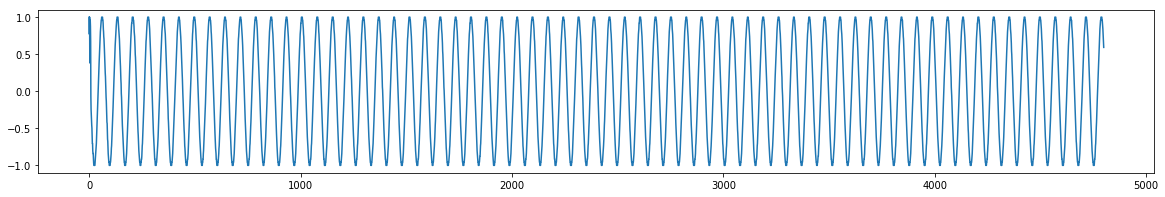

In [35]:
plt.figure(figsize=[20, 3]); plt.plot(output_wav.numpy())

In [36]:
import IPython.display as ipd
ipd.Audio(output_wav.numpy(), rate=sample_rate)

새로운 음원 생성 테스트 

In [0]:
init_wav = output_wav.numpy()
init_wav[:4500] = 0

In [38]:
# generated_wav = np.reshape(init_wav, (1, -1))
generated_wav = mu_law_encode(init_wav, mu)
generated_wav = tf.cast(tf.reshape(generated_wav, (1, -1, 1)), tf.float32).numpy()

time_steps = tqdm_notebook(range(4000))
for i in time_steps:
  sample = generated_wav[:, -int(sec*sample_rate):, :].astype('float32')
  next_sample_logit = wavenet_model(sample)
  next_sample_prob = tf.nn.softmax(next_sample_logit)
  dist = tf.distributions.Categorical(probs=next_sample_prob)
  next_sample = dist.sample()
  next_sample = np.expand_dims(next_sample, -1)
  generated_wav = np.concatenate([generated_wav, next_sample[:, -1:,:]], axis=1)


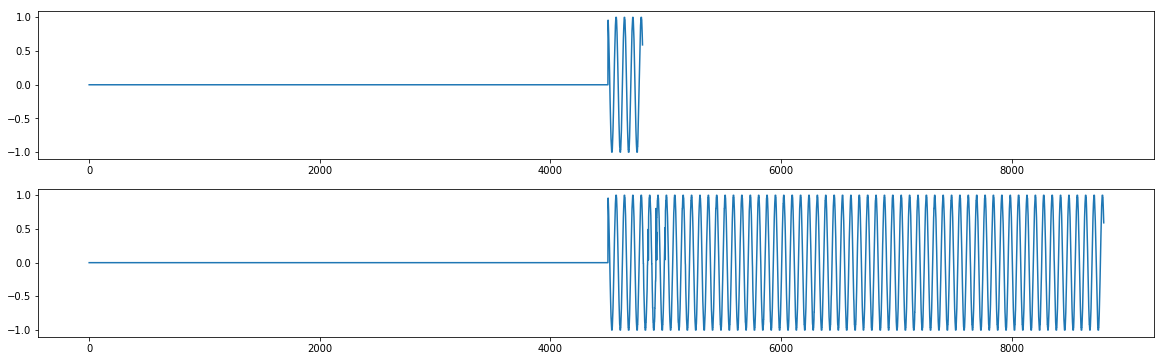

In [39]:
fianl_wav = mu_law_decode(np.squeeze(generated_wav), 256)

plt.figure(figsize=[20, 6])
ax1 = plt.subplot(211)
plt.plot(init_wav)
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(fianl_wav.numpy())

In [42]:
import IPython.display as ipd
ipd.Audio(fianl_wav, rate=sample_rate)